In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
#import seawater

# PWD IS  /g/data/xv83/np1383/src_CAFE60_eqpac_analysis_codesrc_CAFE60_eqpac_analysis/16-transport_test.ipynb

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

In [3]:
cluster

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.150:34019,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load preprocessed Data

In [5]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40))

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
# I cut out ensemble 25 previously, path is '/g/data4/xv83/np1383/processed_data/physics_ds/ .... tx_trans_physics_feb7.nc

# Load Data
dic=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_pac_feb7.nc') #physics_ds
cafe_x_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
cafe_y_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
cafe_x_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto') # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')
# y is v and x is u directions?

adic_cafe=dic['adic'].chunk('auto')
dic_cafe=dic['dic'].chunk('auto')
anth_dic_cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__.chunk('auto')

adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt


cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural


cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
#cafe_co2_anth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})


# Since we are calculating the below in mmol/m3/s, compared to the cafe transport calcs from CAFE which are in sverdrups 1,000,000 m3/s

upwelling_cafe_100=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-100,method='nearest') #
upwelling_cafe_300=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-300,method='nearest') #
upwelling_cafe_500=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-500,method='nearest') #
upwelling_cafe_700=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-700,method='nearest') #
upwelling_cafe_900=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-900,method='nearest') #

upwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_700=(upwelling_cafe_700.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-700,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_700=(upwelling_cafe_700.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-700,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups



anthflux=((cafe_co2_anth*-1)*area_m2)#/1e6 # Or maybe 9? # To Sverdrups (Because skin not m3? I have no idea).
flux=((cafe_co2*-1)*area_m2)#/1e6 #Or mabe 9? To Sverdrups


# EVERYTHING SHOULD BE IN MMOL/S


In [8]:
cafe_x_tx

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [9]:
# mmol/s
#10^9 kg/s

In [10]:
# Compare Area vs Transport??

In [11]:
#area_m2/1e6

### Check some of the vars to make sure they look ok

In [12]:
cafe_x_tx

#mmol/m3 * 1e9 KG/S (/1e6?)

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [13]:
adic_cafe

<xarray.DataArray 'adic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     adic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [14]:
dic_cafe

<xarray.DataArray 'dic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     dic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [15]:
cafe_co2_anth

<xarray.DataArray (time: 720, lat: 140, lon: 170)>
array([[[-8.12692815e-05, -8.05905293e-05, -8.20420464e-05, ...,
                     nan,             nan,             nan],
        [-6.27744885e-05, -6.36629266e-05, -6.60276419e-05, ...,
                     nan,             nan,             nan],
        [-4.99513044e-05, -5.13415143e-05, -5.46429619e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan, -2.59818335e-05, -3.11375188e-05, ...,
         -1.01243699e-04, -1.02947000e-04, -1.06701322e-04],
        [-1.92235748e-05, -3.19972460e-05, -3.46961024e-05, ...,
         -9.25098793e-05, -9.91586639e-05, -1.05985877e-04],
        [-2.11526640e-05, -3.40708648e-05, -3.36802186e-05, ...,
         -7.62597265e-05, -9.34339914e-05, -1.00215228e-04]],

       [[-4.17797819e-05, -3.93452137e-05, -3.69605914e-05, ...,
                     nan,             nan,             nan],
        [-4.07274892e-05, -3.91482645e-05, -3.71795686e-05, ...,
                     nan,             nan,             nan],
        [-4.05038336e-05, -3.78398254e-05, -3.61938655e-05, ...,
                     nan,             nan,             nan],
...
          4.58130380e-05,  3.81436475e-05,  3.83082443e-05],
        [ 6.15766112e-06,  1.95439279e-05,  2.09899772e-05, ...,
          7.02108446e-05,  6.37502671e-05,  5.76455386e-05],
        [ 1.10565015e-05,  2.25717340e-05,  2.25512740e-05, ...,
          6.59838988e-05,  6.79772347e-05,  7.34023342e-05]],

       [[-2.02712654e-05, -2.05903052e-05, -2.09384380e-05, ...,
                     nan,             nan,             nan],
        [-2.01107614e-05, -2.07197882e-05, -2.07053963e-05, ...,
                     nan,             nan,             nan],
        [-1.64308076e-05, -1.72205873e-05, -1.79971030e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,  3.39869730e-05,  3.90992282e-05, ...,
          8.11240679e-05,  6.95347044e-05,  6.75038245e-05],
        [ 1.60184063e-05,  3.96328105e-05,  4.29397187e-05, ...,
          1.07914566e-04,  9.74847426e-05,  9.13539479e-05],
        [ 1.96226829e-05,  4.13808593e-05,  4.16727489e-05, ...,
          1.01620652e-04,  1.07105065e-04,  1.12273679e-04]]],
      dtype=float32)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

## Key Tracer Calculation and Save. 

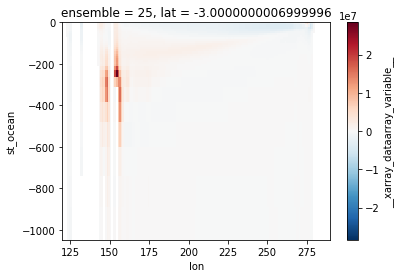

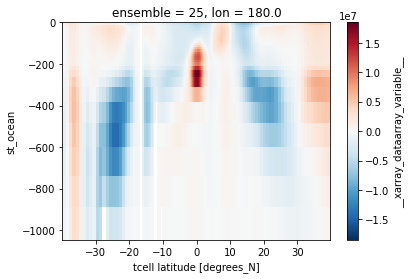

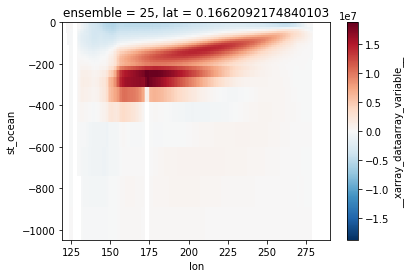

In [16]:
# Run tracer transport Calculation
# This will do the two sides of the box but not vertical (bottom / top)> Make new calc to get wt transport?
calculate_horizontal_tracers=False
if calculate_horizontal_tracers==True:
    names=['anth_dic_cafe','dic_cafe']
    for i,tracer in enumerate([anth_dic_cafe,dic_cafe]):
        tracer_u=tracer.rename({'lon':'lon_x'}).chunk('auto')
        tracer_v=tracer.rename({'lat':'lat_x'}).chunk('auto')

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=False
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx
            tracer_v_tx=tracer_v_interp*cafe_y_tx

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport.nc')
        print('v saved')
        
anth_dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
anth_dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

# Test they look OK

#chunk({'time':-1}).sel(time=slice('2000-01-01','2020-01-01')).
anth_dic_v_tx.mean(dim='time').sel(lat=-3,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
plt.show()
anth_dic_u_tx.mean(dim='time').sel(lon=180,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
plt.show()
anth_dic_u_tx.mean(dim='time').sel(lat=0,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')

In [17]:
#cafe_y_tx_gm.sel(time='2010-01-01',lat_x=3,lon=180,method='nearest').plot()

In [18]:
calculate_horizontal_tracers_gm=False
if calculate_horizontal_tracers_gm==True:
    names=['dic_cafe']  #anth_dic_cafe
    for i,tracer in enumerate([dic_cafe]):# anth_dic_cafe
        tracer_u=tracer.rename({'lon':'lon_x'}).chunk('auto')
        tracer_v=tracer.rename({'lat':'lat_x'}).chunk('auto')

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=False
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx_gm
            tracer_v_tx=tracer_v_interp*cafe_y_tx_gm

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport_gm.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport_gm.nc')
        print('v saved')
        
#anth_dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#anth_dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

## Calculate ENSO Months

In [19]:
#anth_dic_u_tx

In [20]:
#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon

In [21]:
# Function to get total above and below a certain cutoff in the maps.

def xarray_posneg_calc(ds,cutoff=0,mean=False,printer=True,mmols_to_pgYr_convert=True):
    ds1=ds
    if mmols_to_pgYr_convert==True:   
        ds=(ds*60*60*24*12*365)/1e18 # From Seconds to Minute to Hour to Day to Year to Milligrams to Petagrams
    pos=ds.where(ds>cutoff)
    neg=ds.where(ds<-cutoff)
    if mean==True:
        res=[pos.mean().values,neg.mean().values]
    elif mean==False:
        res=[pos.sum().values,neg.sum().values]
    if printer==True:
        print(np.array(res))
        print(ds1.where(ds1>0).mean().values)
    return np.array(res)

In [22]:
dic_transport_through_box=pd.DataFrame()

# Start the Figures

### Plot 1 and 2: North and South Faces

In [23]:
#densitylevs=[1022,1024.5,1026.7]#6.9]
#(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

[ 0.6586061  -0.86354417]
744377.75
[ 0.6825086 -1.0464942]
699851.44
[ 0.69798034 -1.001722  ]
797061.75
[ 0.6617483 -0.8592157]
883607.1


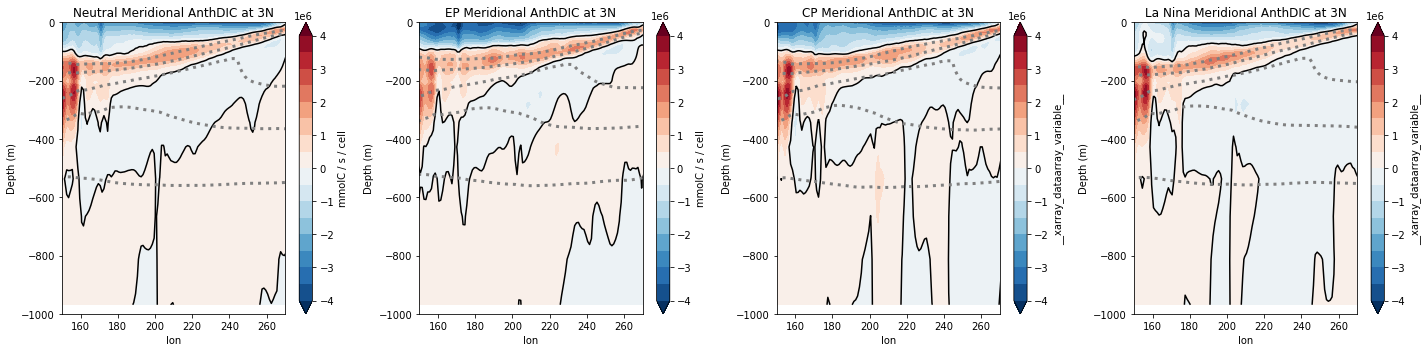

[ 0.97192276 -0.77619845]
1246137.2
[ 0.941491   -0.79348725]
1135497.0
[ 0.9747629 -0.7734688]
1221913.6
[ 1.0821669  -0.81348884]
1634061.2


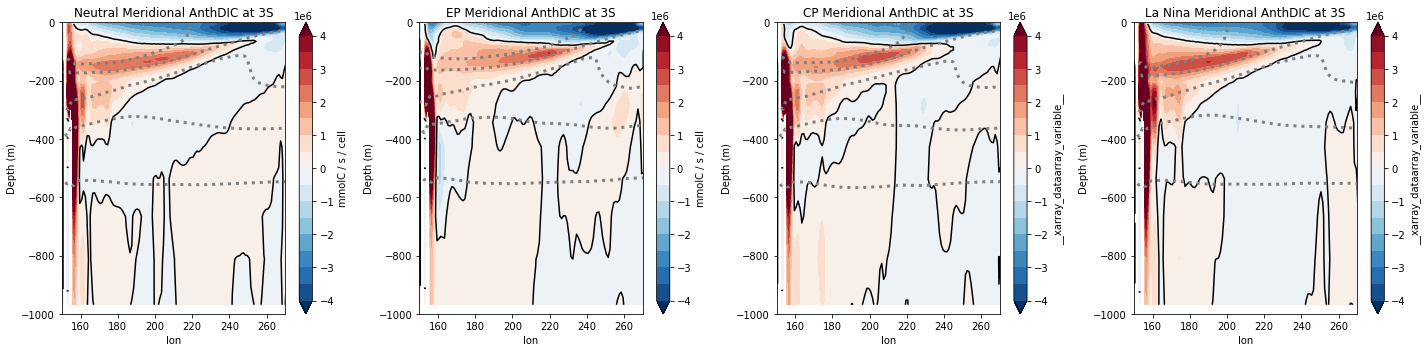

[ 31.257595 -37.592667]
36450864.0
[ 34.353497 -42.766647]
35697412.0
[ 34.93241  -42.738308]
40557244.0
[ 31.964344 -40.572765]
44222628.0


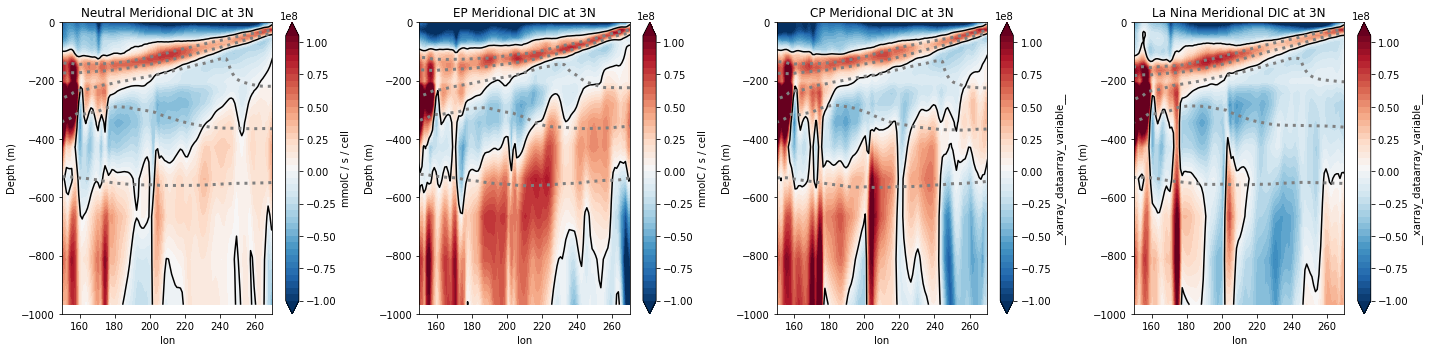

[ 44.027504 -34.50963 ]
58025892.0
[ 42.854485 -34.394215]
51993680.0
[ 46.48682 -34.89436]
59057984.0
[ 49.29171 -38.49962]
75993280.0


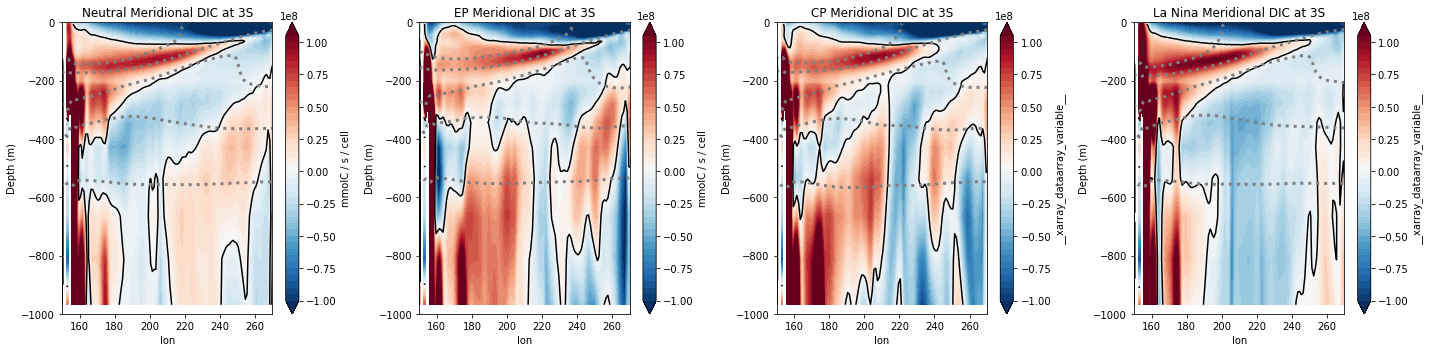

,Neutral,EP,CP,Nina
Meridional AnthDIC in 3N,0.658606,0.682509,0.697980,0.661748
Meridional AnthDIC out 3N,-0.863544,-1.046494,-1.001722,-0.859216
Meridional AnthDIC in 3S,0.971923,0.941491,0.974763,1.082167
Meridional AnthDIC out 3S,-0.776198,-0.793487,-0.773469,-0.813489
Meridional DIC in 3N,31.257595,34.353497,34.932411,31.964344
Meridional DIC out 3N,-37.592667,-42.766647,-42.738308,-40.572765
Meridional DIC in 3S,44.027504,42.854485,46.486820,49.291710
Meridional DIC out 3S,-34.509628,-34.394215,-34.894360,-38.499619


In [24]:
densitylevs=[1023,1024.5,1026.3,1026.7,1027,1027.5]
ylim=-1000
plot=True
if plot==True:
    N_S_data_holder=[anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-1000)),
                     dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-1000))]
                     #((grid_multiplier_lon*(anth_dic_tx_v_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T)]

    N_S_names=['Meridional AnthDIC','Meridional DIC']#,'Old Attempt']


    for i, N_S_data in enumerate(N_S_data_holder):


        for lat in [3,-3]:
            adic_tx_n=N_S_data.sel(lat=lat,method='nearest')#(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T
            if lat==3: 
                direct='3N'
                adic_tx_n=adic_tx_n*-1  # Calculate Transport OUT of the box
            if lat==-3: direct='3S'

            plt.figure(figsize=(20,5))
            plt.subplot(141)
            if ((i==0)|(i==2)): 
                levs=np.arange(-4e6,4.5e6,5e5)
            elif i==1: 
                levs=np.arange(-1e8,1.1e8,5e6)
            #else: levs=np.arange(-10,10,1)
            contour=[0]#60,-60]
            
         

            plt.subplot(141)        
            ax=adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_n.sel(time=neutral_events).mean(dim='time'))
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

            #print(asum)
            plt.title(f'Neutral {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            
            #cbar=plt.colorbar(ax)
            #cbar.set_label()#, rotation=270)

            plt.subplot(142)
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_n.sel(time=ep_events).mean(dim='time'))
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

            #print(asum)
            plt.title(f'EP {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')

            plt.subplot(143)
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_n.sel(time=cp_events).mean(dim='time'))
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

            plt.title(f'CP {N_S_names[i]} at {direct}')

            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            
            plt.subplot(144)
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_n.sel(time=nina_events).mean(dim='time'))
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

            plt.title(f'La Nina {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            plt.tight_layout()
        
            plt.show()
           
            temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            
dic_transport_through_box                                     

In [25]:
anth_dic_u_tx

<xarray.DataArray '__xarray_dataarray_variable__' (time: 731, st_ocean: 30, lat: 140, lon: 171)>
dask.array<mul, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * lon       (lon) float64 120.0 121.0 122.0 123.0 ... 287.0 288.0 289.0 290.0

### Plot 3+4: Western and Eastern Faces

[ 0.6322218  -0.32500243]
5253569.0
[ 0.52827114 -0.39079148]
4445692.5
[ 0.6192118  -0.42778492]
5097372.5
[ 0.64818996 -0.29718542]
5386260.0


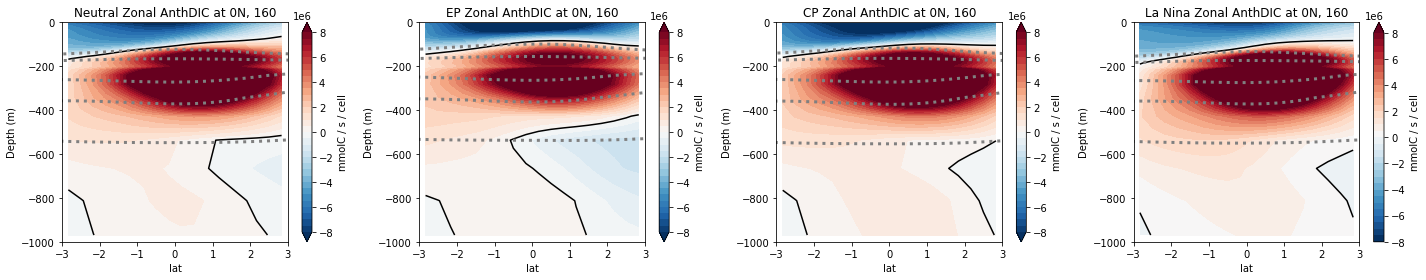

[ 0.11598948 -0.30882376]
2339696.0
[ 0.15499473 -0.299738  ]
2512704.8
[ 0.14629261 -0.29044676]
3451568.8
[ 0.10295731 -0.3197229 ]
1825925.6


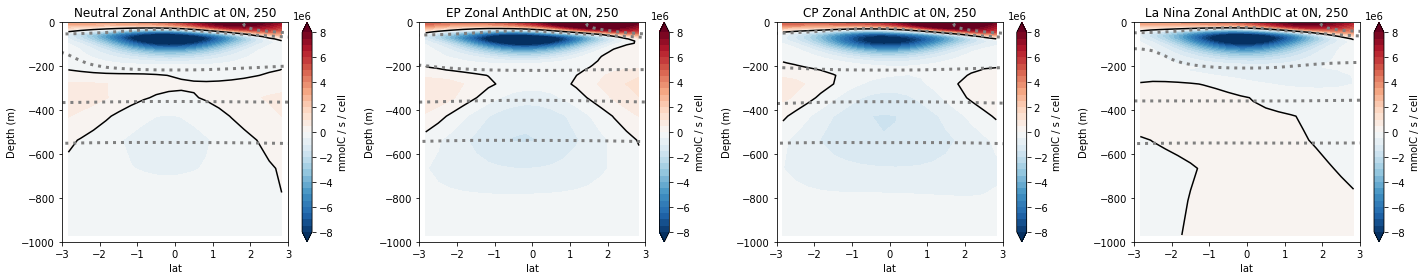

[ 30.963867 -11.498831]
256493680.0
[ 23.790493 -14.345705]
202793420.0
[ 31.546995 -14.672416]
261324080.0
[ 33.999554 -10.070274]
282525900.0


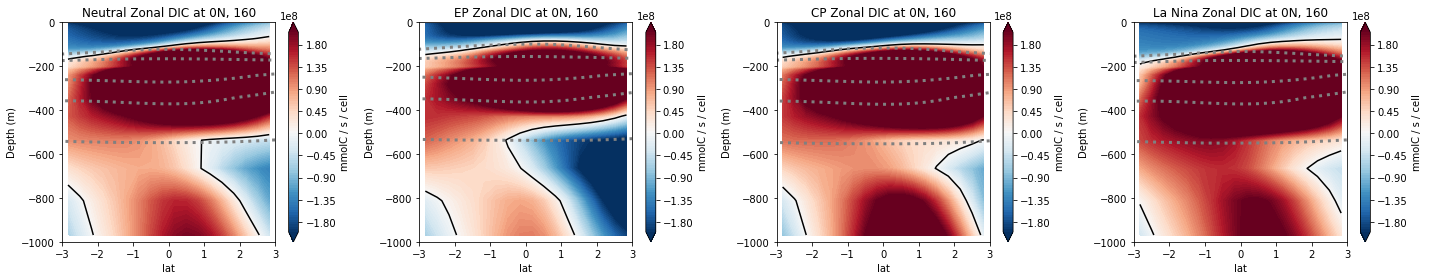

[  5.3075285 -17.605751 ]
114959440.0
[  6.5203776 -18.993362 ]
111883010.0
[  6.0079765 -19.578804 ]
140495340.0
[  4.6657743 -17.47226  ]
104484970.0


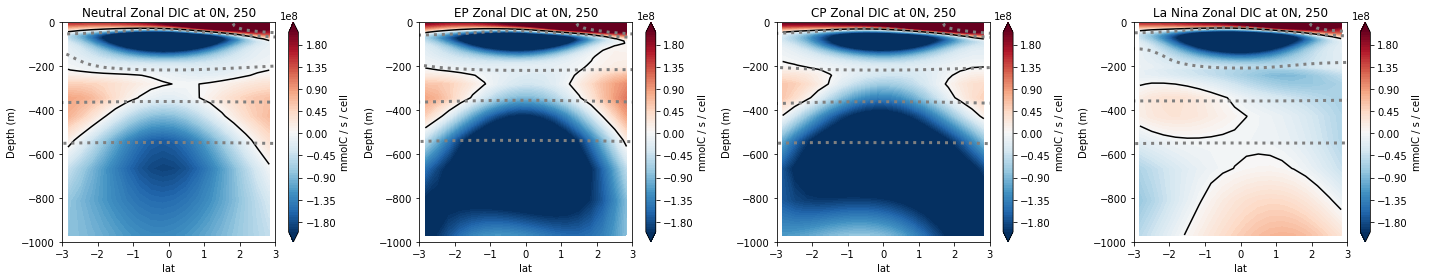

In [26]:
plot=True
if plot==True:

    #anth DIC
    E_W_data_holder=[anth_dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-1000)),
                     dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-1000))]
                     #((grid_multiplier_lat*(anth_dic_tx_u_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T*-1)] # Wrong Direction

    E_W_names=['Zonal AnthDIC','Zonal DIC']#,'Zonal Old Attempt']


    for i, E_W_data in enumerate(E_W_data_holder):
        
        ylim=-1000
    
        lons=[160,250]
        for lon in lons:
            if i==0 or i==2:
                levs=np.arange(-8e6,8.5e6,5e5)#None#np.arange(-20,22,2)
            elif i==1:# or i==3:
                levs=np.arange(-2e8,2.1e8,5e6)#None#np.arange(-1000,1100,100)
                
                
            #elif i<=4:  
            #levs=None#np.arange(-1e7,1e7,1e6)
            contour=[0]#60,-60]
            
            #lon=180
            lslice=slice(-3,3)

            plt.figure(figsize=(20,4))
            #plt.subplot(251)
            plt.subplot(141)

            adic_tx_b=E_W_data.sel(lon=lon,method='nearest').sel(lat=lslice)#.T#grid_multiplier_lat.T*anth_dic_tx_u.sel(lon=lon,method='nearest')#.mean(dim='time')
            if lon==250:
                adic_tx_b*=-1 # Calculate Transport OUT of box. 

            #print(adic_tx_b)
            #(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_b.sel(time=neutral_events).mean(dim='time'))

            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'Neutral {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            
            plt.ylabel('Depth (m)')
            plt.xlim([-3,3])

            plt.subplot(142)
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_b.sel(time=ep_events).mean(dim='time'))
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'EP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            plt.xlim([-3,3])

            plt.subplot(143)
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_b.sel(time=cp_events).mean(dim='time'))
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'CP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.xlim([-3,3])
            plt.ylabel('Depth (m)')

            plt.subplot(144)
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_b.sel(time=nina_events).mean(dim='time'))
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'La Nina {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.xlim([-3,3])
            plt.ylabel('Depth (m)')


            plt.tight_layout()
            plt.show()
            # Mmol DIC/m2/s
            #cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
            
            temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{E_W_names[i]} in {lon}',f'{E_W_names[i]} out {lon}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            #temp_holder

In [27]:
dic_transport_through_box

,Neutral,EP,CP,Nina
Meridional AnthDIC in 3N,0.658606,0.682509,0.697980,0.661748
Meridional AnthDIC out 3N,-0.863544,-1.046494,-1.001722,-0.859216
Meridional AnthDIC in 3S,0.971923,0.941491,0.974763,1.082167
Meridional AnthDIC out 3S,-0.776198,-0.793487,-0.773469,-0.813489
Meridional DIC in 3N,31.257595,34.353497,34.932411,31.964344
Meridional DIC out 3N,-37.592667,-42.766647,-42.738308,-40.572765
Meridional DIC in 3S,44.027504,42.854485,46.486820,49.291710
Meridional DIC out 3S,-34.509628,-34.394215,-34.894360,-38.499619
Zonal AnthDIC in 160,0.632222,0.528271,0.619212,0.648190
Zonal AnthDIC out 160,-0.325002,-0.390791,-0.427785,-0.297185



### Plot 5+6: Upwelling and Outgassing (Vertical Top and Bottom Faces)
upwelling
anthupwelling

flux
anthflux


In [28]:
xarray_posneg_calc(upwelling_dat.sel(time=neutral_events).mean(dim='time').chunk('auto'))

NameError: name 'upwelling_dat' is not defined

In [ ]:
plot=True
if plot==True:

    #anth DIC
    T_B_data_holder=[upwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_700.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_700.sel(time=slice('2000-01-01','2020-01-01')),

                     flux.sel(time=slice('2000-01-01','2020-01-01'))*-1,
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))*-1]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling 100','Anthropogenic Upwelling 100','Upwelling 500','Anthropogenic Upwelling 500','Upwelling 700','Anthropogenic Upwelling 700','CO2 flux', 'anth CO2 flux']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==0:
            levs=None#np.arange(-40,45,5)
        elif i==1:
            levs=None#np.arange(-2,2.2,0.2)
        
        
        else: levs=None
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-3,3)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))

        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat.sel(time=neutral_events).chunk('auto').mean(dim='time'))

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat.sel(time=ep_events).chunk('auto').mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat.sel(time=cp_events).chunk('auto').mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat.sel(time=nina_events).chunk('auto').mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])


        plt.tight_layout()
        plt.show()
         
        temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{T_B_names[i]} in',f'{T_B_names[i]} out'])
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [ ]:
dic_transport_through_box#=dic_transport_through_box[:-8]

In [ ]:
dic_transport_through_box.to_csv('dic_tx.csv')

## End Box Estimate

In [ ]:
dic_transport_through_box
# in PgC/yr???

In [ ]:
#dic_tx_pgC

In [ ]:
#dic_tx_pgC.iloc[-4:]

In [ ]:
dic_transport_through_box=pd.read_csv('dic_tx.csv',index_col=0).replace(0,np.nan)
# Should have been saved in Petagrams.
#dic_tx_pgC=((dic_transport_through_box)*12*60*60*24*365)/1e9 #
dic_transport_through_box.iloc[-4:]=dic_transport_through_box.iloc[-4:]*-1 # Co2 Flux Directions are wrong way around.

# Units are 1e9 mmoles/s
# Pretty sure this is Petagrams. is 15 and 50PG seem correct for meridional and zonal transport of C / yr? Outgassing is like 1, so probably?
# 12 (molC to gC) * seconds *minutes* hours*days / 1e9 (rather than 1e15 since we are in 1,000,000 kg/yr not g. 
#Rather than 1e15 # Because its already in 1,000,000kg/s ??

#dic_transport_through_box=dic_transport_through_box[~dic_transport_through_box.index.str.contains('100')]
#dic_transport_through_box=dic_transport_through_box[~dic_transport_through_box.index.str.contains('500')]



names=dic_transport_through_box.index

old_tx=dic_transport_through_box[names.str.lower().str.contains('old')]
old_tx_anth=old_tx[old_tx.index.str.lower().str.contains('anth')]
for anth in old_tx_anth.index:
    if anth in old_tx.index:
        old_tx=old_tx.drop(anth)
        
new_tx=dic_transport_through_box[~names.str.lower().str.contains('old')]
new_tx_anth=new_tx[new_tx.index.str.lower().str.contains('anth')]
for anth in new_tx_anth.index:
    if anth in new_tx.index:
        new_tx=new_tx.drop(anth)

In [ ]:
plt.figure(figsize=(20,5))
ax=plt.subplot(111)
abs(new_tx).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
#plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
plt.figure(figsize=(20,5))
ax=plt.subplot(111)
abs(new_tx_anth).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
new_tx

In [ ]:
# SORT BY EACH FACE

face_data=[new_tx,new_tx_anth]

box_faces=['3s','3n','160','250','upwelling 500','upwelling 700','upwelling 100','flux']
box_faces=['3s','3n','160','250','upwelling 700','flux']


for i,df in enumerate(face_data):
    
    box_res=pd.DataFrame()
    for face in box_faces:
        result=df[df.index.str.lower().str.contains(face)]
        #print(result)
        result1=result.mean()
        result1.name=face
        #print(result.mean())
        box_res=box_res.append(result1)
        #print(result)
    if i==0:
        print('Total DIC transport')
    elif i==1:
        print('Anth DIC transport')
        
    plt.figure(figsize=(12,8))
    ax=plt.subplot(111)
    box_res.plot.bar(ax=ax)
    plt.axhline(0,c='k')
    plt.show()
    
    print(box_res)
    #plt.figure(figsize=(12,5))
    print(box_res.mean())
    box_res.mean().plot.bar()
    plt.axhline(0,c='k')
    plt.show()

In [ ]:
# SORT BY IN AND OUT
# Calculate Total In / Out transport
face_data=[new_tx,new_tx_anth]
box_faces=[' in',' out']
for a,df in enumerate(face_data):
    box_res=pd.DataFrame()
    for i,face in enumerate(box_faces):
        
        direction=df[df.index.str.lower().str.contains(face)]
        result2=direction.mean()
        result2.name=str(face[1:])
        box_res=box_res.append(result2)
        #print(direction)
    if a==0:
        print(f'Total DIC transport {face}')
    elif a==1:
        print(f'Anth DIC transport {face}')
    print(box_res)
    print(box_res.mean())
#        print(box_res.mean())

In [ ]:
# Richards Depth Grid Calculation

docn=phys
mdepth=docn.st_ocean.copy()
dbot=np.copy(docn.sw_ocean)
dthick=dbot*0
dthick[1:50]=dbot[1:50]-dbot[0:49]

dthick[0]=dbot[0]
print(dthick,dbot)
mdepth=mdepth*0+dthick
mdepth